In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import numpy as np
import pandas as pd
from dropout_rnn import DropoutLSTM
from stochastic_module import StochasticDualOutputModule
from train_utils import weight_coefficient, bias_coefficient, filter_parameters, train_model

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import minmax_scale

In [3]:
from classification_uncertainty_utils import aleatoric_uncertainty, epistemic_uncertainty, uncertainty_avg, prediction_avg

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
np.random.seed(1234)
torch.manual_seed(1234)

In [6]:
training_table = pd.read_table("./data/hill-valley/Hill_Valley_with_noise_Training.data", sep=',', dtype=np.float32)
testing_table = pd.read_table("./data/hill-valley/Hill_Valley_with_noise_Testing.data", sep=',', dtype=np.float32)

In [7]:
training_table.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X92,X93,X94,X95,X96,X97,X98,X99,X100,class
0,39.020000,36.490002,38.200001,38.849998,39.380001,39.740002,37.020000,39.529999,38.810001,38.790001,...,36.619999,36.919998,38.799999,38.520000,38.070000,36.730000,39.459999,37.500000,39.099998,0.0
1,1.830000,1.710000,1.770000,1.770000,1.680000,1.780000,1.800000,1.700000,1.750000,1.780000,...,1.800000,1.790000,1.770000,1.740000,1.740000,1.800000,1.780000,1.750000,1.690000,1.0
2,68177.687500,66138.421875,72981.882812,74304.328125,67549.656250,69367.343750,69169.406250,73268.609375,74465.843750,72503.367188,...,73438.882812,71053.351562,71112.617188,74916.476562,72571.578125,66348.968750,71063.718750,67404.273438,74920.242188,1.0
3,44889.058594,39191.859375,40728.460938,38576.359375,45876.058594,47034.000000,46611.429688,37668.320312,40980.890625,38466.148438,...,42625.671875,40684.199219,46960.730469,44546.800781,45410.531250,47139.441406,43095.679688,40888.339844,39615.191406,0.0
4,5.700000,5.400000,5.280000,5.380000,5.270000,5.610000,6.000000,5.380000,5.340000,5.870000,...,5.170000,5.670000,5.600000,5.940000,5.730000,5.220000,5.300000,5.730000,5.910000,0.0


In [8]:
dim = 1
seq_length = 100
DROP = 0.5
ls = 1e-2
tau = 1

In [9]:
x_train = minmax_scale(training_table.drop("class", axis=1).values, axis=1)
y_train = torch.tensor(training_table["class"].values)
x_test = minmax_scale(testing_table.drop("class", axis=1).values, axis=1)
y_test = torch.tensor(testing_table["class"].values)

x_train = torch.tensor(np.expand_dims(x_train, axis=-1))
x_test = torch.tensor(np.expand_dims(x_test, axis=-1))

N = len(y_train)

train_dl = torch.utils.data.DataLoader(
        [(x_train[i], y_train[i]) for i in range(len(y_train))],
        batch_size=10,
        shuffle=True
)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = DropoutLSTM(1, 10, DROP)
        self.fc = nn.Linear(10, 1)

    def forward(self, x: torch.Tensor):
        out, _ = self.rnn(x)
        out = out[-1]
        #out = out.transpose(-2,-3).flatten(-2)
        out = torch.tanh(out)
        pre_sigmoid = self.fc(out).flatten()
        post_sigmoid = torch.sigmoid(pre_sigmoid)
        return pre_sigmoid, post_sigmoid

In [11]:
net = Net()
def criterion(pre_sigmoid, post_sigmoid, label):
    return nn.functional.binary_cross_entropy_with_logits(pre_sigmoid, label)

M = filter_parameters(net.named_parameters(), "rnn", "weight")
m = filter_parameters(net.named_parameters(), "rnn", "bias")
other_params = filter_parameters(net.named_parameters(), "fc", "")

parameters = [
    {"params": M, "weight_decay": weight_coefficient(ls, tau, DROP, N)}, # dropout rnn weight
    {"params": m, "weight_decay": bias_coefficient(ls, tau, N)}, # dropout rnn bias
    {"params": other_params} # other parameters
]
optimizer = optim.Adam(parameters, lr=1e-3)

In [12]:
train_model(net, train_dl, criterion, optimizer, 5)

[1, 100.00%] loss: 0.668787
[2, 100.00%] loss: 0.608871
[3, 100.00%] loss: 0.458635
[4, 100.00%] loss: 0.283135
[5, 100.00%] loss: 0.212357
Finish training


In [13]:
stochastic_net = StochasticDualOutputModule(net)

In [14]:
stochastic_net.eval()
with torch.no_grad():
    _, outputs = stochastic_net(x_test.transpose(-2, -3))
    uncertainties = uncertainty_avg(outputs)
    predictions = prediction_avg(outputs)

In [15]:
roc_auc_score(y_test, predictions)

1.0

In [16]:
A = aleatoric_uncertainty(outputs)
E = epistemic_uncertainty(outputs)

In [17]:
for i in range(10):
    print("Entry %3i: label (%.0f), prediction (%.4f), uncertainty (%.4f), aleatoric (%.6f), epistemic (%.6f)" % (i, y_test[i], predictions[i], uncertainties[i], A[i], E[i]))

Entry   0: label (1), prediction (0.8156), uncertainty (0.1504), aleatoric (0.147565), epistemic (0.002856)
Entry   1: label (0), prediction (0.1123), uncertainty (0.0997), aleatoric (0.099534), epistemic (0.000167)
Entry   2: label (0), prediction (0.1223), uncertainty (0.1074), aleatoric (0.107085), epistemic (0.000279)
Entry   3: label (1), prediction (0.8545), uncertainty (0.1243), aleatoric (0.124183), epistemic (0.000115)
Entry   4: label (1), prediction (0.7983), uncertainty (0.1610), aleatoric (0.152483), epistemic (0.008558)
Entry   5: label (0), prediction (0.1082), uncertainty (0.0965), aleatoric (0.096370), epistemic (0.000154)
Entry   6: label (0), prediction (0.1280), uncertainty (0.1116), aleatoric (0.111076), epistemic (0.000571)
Entry   7: label (0), prediction (0.1120), uncertainty (0.0994), aleatoric (0.099291), epistemic (0.000128)
Entry   8: label (0), prediction (0.1304), uncertainty (0.1134), aleatoric (0.111719), epistemic (0.001698)
Entry   9: label (1), predic

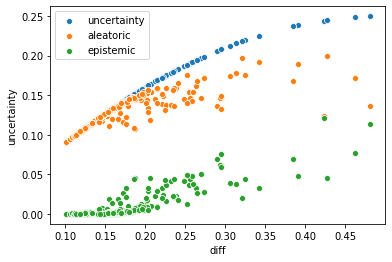

In [18]:
dist = torch.abs(y_test - predictions)
sns.scatterplot(x=dist, y=uncertainties)
sns.scatterplot(x=dist, y=A)
sns.scatterplot(x=dist, y=E)
plt.xlabel("diff")
plt.ylabel("uncertainty")
plt.legend(labels=['uncertainty', 'aleatoric', 'epistemic'])

### Spread pre and post sigmoid analysis

In [19]:
stochastic_net.eval()
with torch.no_grad():
    pre_sigmoid, post_sigmoid = stochastic_net(x_test.transpose(-2, -3))

In [23]:
T, B = pre_sigmoid.shape
pre_sigmoid_df = pd.DataFrame(columns=["entry","value"])
post_sigmoid_df = pd.DataFrame(columns=["entry","value"])
for i in range(T):
    for j in range(20):
        pre_sigmoid_df.loc[i*B + j] = (j+1, pre_sigmoid[i,j])
        post_sigmoid_df.loc[i*B + j] = (j+1, post_sigmoid[i,j])

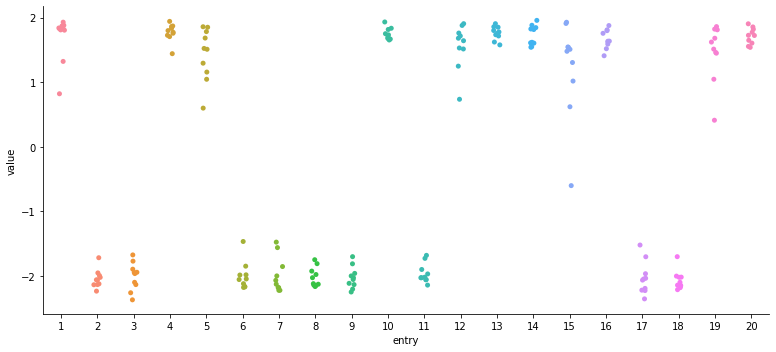

In [24]:
plot = sns.catplot(x="entry", y="value", data=pre_sigmoid_df)
plot.fig.set_figwidth(12)

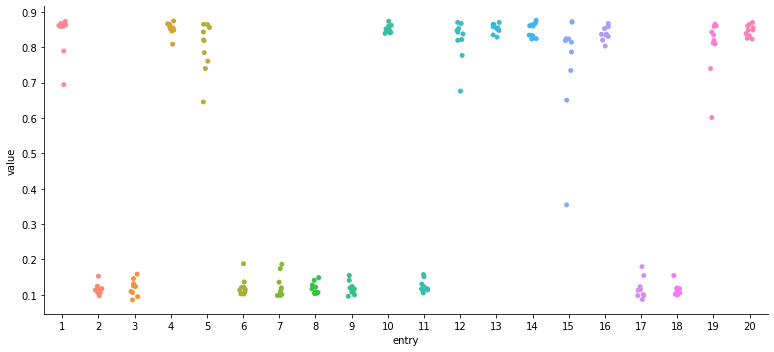

In [25]:
plot = sns.catplot(x="entry", y="value", data=post_sigmoid_df)
plot.fig.set_figwidth(12)

### Flat line test

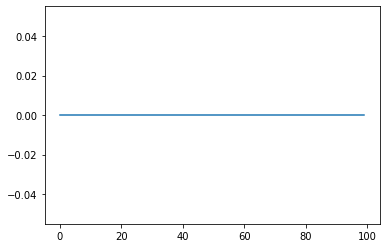

predictions tensor([0.8597, 0.8632])
uncertainties tensor([0.1206, 0.1181])


In [28]:
new_x_test = minmax_scale(np.full((2, 100), 3., dtype=np.float32), axis=1)
new_x_test = np.expand_dims(new_x_test, axis=-1)
new_x_test = new_x_test.swapaxes(-2,-3)
new_x_test = torch.tensor(new_x_test)

stochastic_net.eval()
with torch.no_grad():
    _, outputs = stochastic_net(new_x_test)
    uncertainties = uncertainty_avg(outputs)
    predictions = prediction_avg(outputs)

plt.plot(new_x_test[:,0])
plt.show()
print("predictions", predictions)
print("uncertainties", uncertainties)

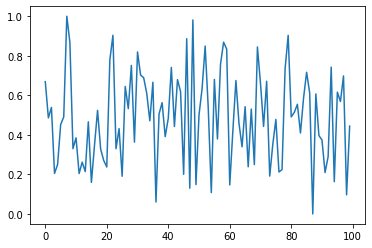

predictions tensor([0.3157, 0.3283])
uncertainties tensor([0.2161, 0.2205])


In [30]:
new_x_test = minmax_scale(np.random.randn(2, 100).astype(np.float32), axis=1)
new_x_test = np.expand_dims(new_x_test, axis=-1)
new_x_test = new_x_test.swapaxes(-2,-3)
new_x_test = torch.tensor(new_x_test)

stochastic_net.eval()
with torch.no_grad():
    _, outputs = stochastic_net(new_x_test)
    uncertainties = uncertainty_avg(outputs)
    predictions = prediction_avg(outputs)

plt.plot(new_x_test[:,0])
plt.show()
print("predictions", predictions)
print("uncertainties", uncertainties)

### Note
In binary classification, the maximum uncertainty is 0.25 (need to verify this), and the minimum is 0.